# **Drowsiness Detection System**

**Importing Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import shutil
import random
import math
import tensorflow_datasets as tfds

**Checking TensorFlow Version**

In [2]:
from tensorflow.python import keras
print(keras.__version__)

2.6.0


**Creating a Folder to Store TFRecords**

In [3]:
!mkdir images

**Function to Convert Arrays to Binary Stream**

In [4]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): 
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

**Function to Convert A Sample to Binary Stream**

In [5]:
def serialize_example(image,label):
    feature = {
        'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label':_bytes_feature(tf.io.serialize_tensor(label))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


**Function to Create TF Records from Binary Stream Objects**

In [6]:
def tf_writer(op_path,filelist):
    classes=['Closed','Open']
    with tf.io.TFRecordWriter(op_path) as writer:
                random.shuffle(filelist)
                for fn in filelist:
                    label = np.array([0,0],dtype='float64')
                    img = open(fn,'rb').read()
                    lab = fn.split('/')[-2]
                    lab = classes.index(lab)
                    label[lab] = 1.0
                    tf_example = serialize_example(img,label)
                    writer.write(tf_example)

**Creating records path**

In [16]:
def create_records(path1,path2):
    opr1 = "/kaggle/working/images/train"
    opr2 = "/kaggle/working/images/val"
    files_list = glob(path1+'/Closed/*') + glob(path2+'/Closed/*')
    files_list1 = glob(path1+'/Open/*') + glob(path2+'/Open/*')
    train_list = files_list[:math.ceil(len(files_list)*0.8)]  +  files_list1[:math.ceil(len(files_list1)*0.8)]
    val_list = files_list[math.ceil(len(files_list)*0.8):]  +  files_list1[math.ceil(len(files_list1)*0.8):]
    tf_writer(opr1,train_list)
    tf_writer(opr2,val_list)

**Calling all the above Functions**

In [17]:
create_records("/kaggle/input/yawn-eye-dataset-new/dataset_new/train","/kaggle/input/yawn-eye-dataset-new/dataset_new/test")

**Below Functions create TF Dataset from TFRecords effeciently**

In [26]:
def parse_image(example):
    feature = {'image':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image = tf.io.decode_jpeg(features['image'],channels = 3)
    image = tf.image.resize(image,[256,256])
    image = tf.image.rgb_to_grayscale(image)
    label = tf.io.parse_tensor(features['label'], out_type=tf.float64)
    label = tf.reshape(label,shape=(2,))
    return image,label
def read_dataset(filename,batchs):
    data = tf.data.TFRecordDataset(filename)
    ds = configure(data)
    return ds
    
def configure(data):
    data = data.map(parse_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    data = data.shuffle(500)
    data = data.batch(32,drop_remainder = True)
    data = data.repeat()
    data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return data

**Calling the above functions to Create a full TF dataset**

In [27]:
def use_records():
    train = read_dataset("./images/train",32)
    val = read_dataset("./images/val",32)
    return train,val
train_ds,val_ds= use_records()  

In [28]:
train_ds,val_ds

(<PrefetchDataset shapes: ((32, 256, 256, 1), (32, 2)), types: (tf.float32, tf.float64)>,
 <PrefetchDataset shapes: ((32, 256, 256, 1), (32, 2)), types: (tf.float32, tf.float64)>)

**Checking the shape of a batch in our TF Dataset**

In [58]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 256, 256, 1)
Label:  (32, 2)


**Visualising a Sample**

Label:  [1. 0.]


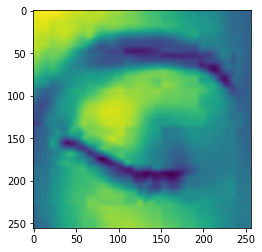

In [80]:
#Label 1 , 0 => Open eye & Label 0 , 1 => Closed eye
for image, label in train_ds.take(1):
  print("Label: ", label.numpy()[0])
  plt.imshow(image.numpy()[0].astype("uint8"))

**Creating CallBacks to choose the choose the epoch's weight that gives the best score**

In [82]:
cb = [tf.keras.callbacks.ModelCheckpoint("./first_model.h5",monitor='val_accuracy',save_best_only=True,mode='max')]

**Building CNN Architecture**

In [83]:
def build():
  model = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip(mode="horizontal"),
  tf.keras.layers.RandomRotation(0.4, fill_mode='reflect',interpolation='bilinear'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
 ])
  model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])
  return model  

**Calling CNN Architecture Function**

In [84]:
model = build()

**Training our own scratch-built CNN**

In [85]:
deep_model = model.fit(train_ds,epochs=10,steps_per_epoch=math.ceil(3200/32),validation_data=val_ds,validation_steps = math.ceil(800/32),callbacks=cb)


Epoch 1/10
100/100 [==============================] - 17s 87ms/step - loss: 0.3862 - accuracy: 0.8191 - val_loss: 0.2301 - val_accuracy: 0.9062
Epoch 2/10
100/100 [==============================] - 8s 84ms/step - loss: 0.2377 - accuracy: 0.9038 - val_loss: 0.2305 - val_accuracy: 0.9237
Epoch 3/10
100/100 [==============================] - 9s 87ms/step - loss: 0.2312 - accuracy: 0.9103 - val_loss: 0.2123 - val_accuracy: 0.9212
Epoch 4/10
100/100 [==============================] - 7s 71ms/step - loss: 0.2107 - accuracy: 0.9128 - val_loss: 0.2378 - val_accuracy: 0.9150
Epoch 5/10
100/100 [==============================] - 10s 98ms/step - loss: 0.1992 - accuracy: 0.9203 - val_loss: 0.2927 - val_accuracy: 0.8863
Epoch 6/10
100/100 [==============================] - 8s 85ms/step - loss: 0.1940 - accuracy: 0.9216 - val_loss: 0.2062 - val_accuracy: 0.9287
Epoch 7/10
100/100 [==============================] - 8s 80ms/step - loss: 0.1802 - accuracy: 0.9237 - val_loss: 0.1980 - val_accuracy: 0.93

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (32, 256, 256, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (32, 256, 256, 1)         0         
_________________________________________________________________
random_flip (RandomFlip)     (32, 256, 256, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (32, 256, 256, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 32)        9

**Visualsing Our Model's Performance**

<AxesSubplot:>

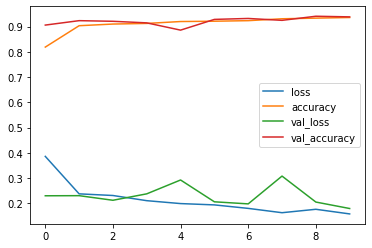

In [87]:
pd.DataFrame(deep_model.history).plot()

**Importing the best model to Test Our Model**

In [88]:
loaded_model = tf.keras.models.load_model("./first_model.h5")

In [92]:
loaded_model.evaluate(val_ds,steps = math.ceil(800/32))

25/25 [==============================] - 2s 49ms/step - loss: 0.2045 - accuracy: 0.9413


[0.2044886201620102, 0.9412500262260437]